<a href="https://colab.research.google.com/github/IgnotusGrim/Digitales-Proyecto-1/blob/main/Tarea_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introducción al Reconocimiento de Patrones
Tarea #5: Aglomeración
Roger Morales Monge

El objetivo de esta tarea es analizar el metodo K-means como metodo de aglomeracion ademas del metodo de PCA como una forma de reducir y proyectar los datos a un espacio bidimensional.

#Librerias de Python
Las bibliotecas necesarias para la ejecucion de todo el codigo son las siguientes:


In [111]:

#De las librerias generales:
from time import time #Usado en el ejemplo original de Kmeans
import numpy as np #Metodos numericos utiles para el manejo de los datos
import matplotlib.pyplot as plt #Para mostrar los resultados gráficamente

#De las librerias de Scikit-Learn:
from sklearn import  metrics #Para evaluar modelos
from sklearn.cluster import KMeans #El modelo de clustering que se utilizará
from sklearn.decomposition import PCA #El metodo utilizado como reductor de dimensiones
from sklearn.preprocessing import StandardScaler #Para normalizar los datos
from sklearn.datasets import load_digits #Para importar MNIST 8x8

#De las librerias de Keras/Tensorflow:
import tensorflow as tf #importar tensorflow
from tensorflow import keras #importar keras
from keras.datasets import mnist #Para usar MNIST 28x28
from keras.utils import np_utils #Para codificar las etiquetas


#Funciones utilizadas para todo el codigo
Algunas funciones que se usaran durante la ejecucion de todo el codigo
para mostrar datos.

In [112]:
#Algunas lineas que no son funciones pero se utilizaran igualmente
#en todo el codigo:

np.random.seed(42)#Semilla determinada para la "aleatoriedad"
#scaler8=StandardScaler() #Normalizador para los datos
#scaler28=StandardScaler()
sample_size=300
n=2000
samples28=np.random.choice(range(60000),n) #Una muestra de n datos para el conjunto MNIST 28x28

In [113]:
#Algoritmo del codigo original usado para evaluar las metricas de un estimador:
def bench_k_means(estimator, name, data,labels):
    t0 = time()
    estimator.fit(data)
    
    print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
    print(82 * '_')
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [114]:
#Funcion para mostrar varias imagenes juntas en un arreglo:
#Tomada de: https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html
def plot_gallery(images, titles, h, w, n_row=2, n_col=5):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    plt.suptitle('Centroides para una aglomeracion de %i clusters:' %len(images))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [115]:
#Funcion que muestra el espacio bidimensional con teselación de Voronoi
#y distintos centroides.
def plotting(xx,yy,Z,data,c1=[],c2=[],title=''):
  Z = Z.reshape(xx.shape)
  plt.figure(1)
  plt.clf()
  plt.imshow(Z, interpolation='nearest',
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap='tab20',
            aspect='auto', origin='lower')
  plt.plot(data[:,0], data[:,1], 'k.', markersize=2)

  # Plot de los primeros centroides con X blancas:
  if c1!=[]:
    plt.scatter(c1[:, 0], c1[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)

  # Plot de los segundos centroides con + blancos:
  if c2!=[]:
    plt.scatter(c2[:, 0], c2[:, 1],
                marker='+', s=169, linewidths=3,
                color='w', zorder=10)

  plt.title(title)
  plt.xlim(data[:,0].min(), data[:,0].max())
  plt.ylim(data[:,1].min(), data[:,1].max())
  plt.xticks(())
  plt.yticks(())
  plt.show()

In [116]:
#Una funcion para mostrar centroides como imagenes para distinto numero de clusters:
def showcentroids(x,pca,ks):
  for k in ks:
    kclass=KMeans(n_clusters=k,init='k-means++',n_init=10)
    kclass.fit(x)
    y=kclass.cluster_centers_
    y=pca.inverse_transform(y)
    #y=N.inverse_transform(y) #revert normalization
    samples,features=y.shape
    dim=int(np.sqrt(features))
    titles=range(k)
    if (np.mod(k,5)==0):
      plot_gallery(y,titles,dim,dim,n_col=int(k/5),n_row=5)
    else:
      plot_gallery(y,titles,dim,dim,n_col=k,n_row=1)


#Carga y Preprocesado de Datos
Primero se cargan los datos que se utilizaran en todo el codigo y procesan:

In [117]:
#MNIST de 8x8:

x_digits,y_digits=load_digits(return_X_y=True)

#Extracción de caracteristicas acerca de los datos:
nsamples,nfeatures=x_digits.shape #numero de datos y dimensiones
ndigits=len(np.unique(y_digits)) #Numero de clases o digitos distintos
labels8=y_digits #Etiquetas del digito correspodiente a cada dato
data8=x_digits



print("ndigits: %d, \t nsamples %d, \t nfeatures %d"
      % (ndigits, nsamples, nfeatures))


ndigits: 10, 	 nsamples 1797, 	 nfeatures 64


In [118]:
#MNIST de 28x28:
(traindigits,trainlabels),(testdigits,testlabels)=mnist.load_data()
#(traindigits,trainlabels)=(traindigits[0:1000],trainlabels[0:1000])#Para calculos rapidos
#Extraccion de caracteristicas:
trainsamples,h,w=traindigits.shape
nfeatures2=h*w

#Normalizacion de los datos:
data28=traindigits.reshape(trainsamples,nfeatures2)
data28=data28.astype('float16')


labels28=trainlabels

print("ndigits: %d, \t nsamples %d, \t nfeatures %d"
      % (ndigits, trainsamples, nfeatures2))
print(labels8)

ndigits: 10, 	 nsamples 60000, 	 nfeatures 784
[0 1 2 ... 8 9 8]


# I Parte: Codigo original de K-Means
En este codigo se presenta un ejemplo de aglomeración de datos en imagenes de 8x8 proyectados a un espacio 2D para un conjunto de digitos escritos a mano (MNIST).

El codigo puede consultarse en:http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

#Incializaciones del Algoritmo K-Means
**Forgy:**
  Inicializa escogiendo *k* puntos de los datos al azar como centroides iniciales. Tiene sentido pues es probable que los clusters esten cercanos a los datos.

**Partición Aleatoria:**
  Asigna aleatoriamente cada punto de los datos a un cluster determinado, los agrupa para definir los clusters y obtiene sus medias para usarlas como centroides iniciales.

**Kmeans++:**
  Es el metodo estandar, escoge puntos iniciales lo mas alejados posible entre si. Luego utiliza distribuciones probabilisticas proporcionales al cuadrado de la distancia entre los primeros dos puntos para estimar los demas inicios.

Tambien pueden escogerse centroides especificos para inicializar el algoritmo.

#Criterios de Evaluación:
**Inertia:**
  Es el dual de la perdida, *K-means* busca minimizar la inercia donde esta expresa la medida de coherencia interna entre los *clusters*. Es sensible a *clusters* anisotropicos.

**Homogeneity:**
  Un estimador muy homogeneo es aquel que contiene solo miembros de una clase en un *cluster*, es similar a medir la cantidad de verdaderos positivos, por lo que es un equivalente de la precision.

**Completness:**
  Un estimador con alta completitud es aquel en el que todos los miembros de una clase son asignados al mismo *cluster*. En ese sentido es un dual de la exhaustividad.

**V_measure:**
  Combina *Homogeneity* and *Completness* en una sola metrica, se puede ver como el dual del *F1 score* y se interpretaria como una medida de concordancia entre dos clasificaciones independientes del mismo set de datos.

**Adjust Mutual Info Score:**
  Mide la similitud de dos clasificaciones ignorando las permutaciones y normalizando probabilisticamente. La medida es simetrica.

**Adjust Mutual Info Score:**
  Mide la correlacion de dos clasificaciones ignorando la permutacion y normalizando probabilisticamente. Tambien es simetrico.

**Silhoutte:**
  Permite evaluar sin conocer las etiquetas. Mide la capacidad del estimador para identificar clusters bien definidos. Numeros cercanos a +1 indican que el numero de clusters es correcto y los datos estan bien definidos dentro de las aglomeraciones a las que fueron asignados.







In [119]:
#Probando varias inicializaciones para un aglomerador K-Means:

#Inicializacion k-means++:
print('\n Inicialización K-Means++:\n')
kclass=KMeans(init='k-means++',n_clusters=ndigits,n_init=10)
bench_k_means(kclass,name='k-means++',data=data8,labels=labels8)

#Inicializacion random:
print('\n Inicialización Random:\n')
kclass=KMeans(init='random',n_clusters=ndigits,n_init=10)
bench_k_means(kclass,name='random',data=data8,labels=labels8)

#Inicializacion especifica, en este caso, dada por las componentes
#principales de los datos:
pca=PCA(n_components=ndigits).fit(data8)

#el n_init es 1 porque se quiere que los iniciadores sean muy especificos, 
#no hace falta buscar cual de todas la incializaciones realizadas son las mejores:
print('\n Inicialización con las Componentes Principales:\n')
kclass=KMeans(init=pca.components_,n_clusters=ndigits,n_init=1)
bench_k_means(kclass,name='PCA-Based',data=data8,labels=labels8)




 Inicialización K-Means++:

init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________
k-means++	0.31s	1165499	0.734	0.744	0.739	0.659	0.736	0.187

 Inicialización Random:

init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________
random   	0.23s	1165149	0.740	0.748	0.744	0.668	0.741	0.183

 Inicialización con las Componentes Principales:

init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________
PCA-Based	0.07s	1188310	0.784	0.787	0.785	0.741	0.783	0.170


**Algunas observaciones:**
El metodo estandar *k-means++*  consigue una menor inercia, pero es lento y en general su desempeño no es peor que las demas.
Por otro lado el metodo random es mas veloz y tiene un desempeño intermedio.
Por ultimo en el uso de las componentes principales como centroides inicializadores, se puede ver que con este metodo el algoritmo converge extremadamente rapido y tiene metricas que en general muestran un desempeño mejor al de las demas inicializaciones.










#Visualización de Resultados:
Para este ejemplo la idea es proyectar los datos de entrenamiento en un espacio bidimensional, reduciendo los vectores de 64 a 2 dimensiones. Luego se usa K-means para clasificar los datos en el espacio 2D y presentar la *Teselación de Voronoi* que asigna cada punto del espacio a su respectiva clase.

In [120]:
#Primero se proyecta el espacio de 64 Dimensiones a 2D:
pca8=PCA(n_components=2)
pca8.fit(data8)
reduced_data8=pca8.transform(data8)

#Luego se entrena el algoritmo de clustering y se aglomeran los datos:
kmeans8=KMeans(init='k-means++',n_clusters=ndigits,n_init=10)
kmeans8.fit(reduced_data8)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [121]:
#Ahora se crea una grid para predecir en todo el espacio y mostrar
#la Teselacion de Voronoi:
step=.02

x_min, x_max = reduced_data8[:, 0].min() - 1, reduced_data8[:, 0].max() + 1
y_min, y_max = reduced_data8[:, 1].min() - 1, reduced_data8[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

#Y se Predice:
Z=kmeans8.predict(np.c_[xx.ravel(),yy.ravel()])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


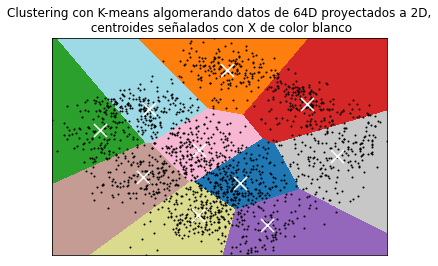

In [122]:
#Ahora se muestran los espacios bidimensionales:
c1=kmeans8.cluster_centers_
title=('Clustering con K-means algomerando datos de 64D proyectados a 2D,\n centroides señalados con X de color blanco')
plotting(xx,yy,Z,reduced_data8,c1,title=title)

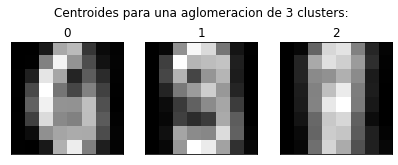

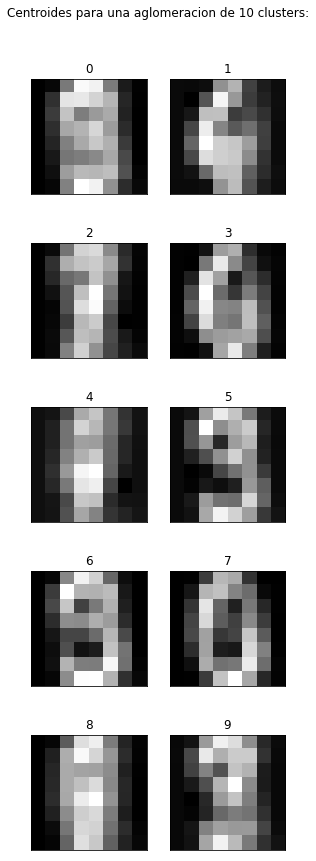

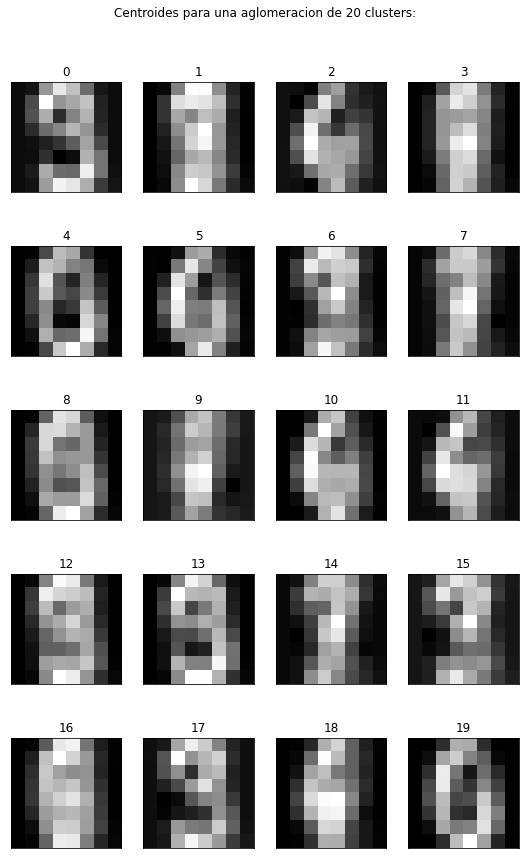

In [123]:
#Ahora, para mostrar los centroides como imagenes es necesario revertir
#la normalizacion y la proyeccion del PCA:
k=[3,10,20]
showcentroids(reduced_data8,pca8,k)


#II Parte: Aglomeración con MNIST 28x28
Ahora se modifica el codigo original con el fin de realizar las mismas pruebas y obtener resultados para el set de imagenes de 28x28 pixeles.

**Debido a que el MNIST 28x28 contiene 60000 imagenes de entrenamiento, la ejecución de las celdas puede tardar bastante***

In [124]:
#Probando varias inicializaciones para un aglomerador K-Means:

#Inicializacion k-means++:
print('\n Inicialización K-Means++:\n')
kclass=KMeans(init='k-means++',n_clusters=ndigits,n_init=10)
bench_k_means(kclass,name='k-means++',data=data28,labels=labels28)

#Inicializacion random:
print('\n Inicialización Random:\n')
kclass=KMeans(init='random',n_clusters=ndigits,n_init=10)
bench_k_means(kclass,name='random',data=data28,labels=labels28)

#Inicializacion especifica, en este caso, dada por las componentes
#principales de los datos:
pca=PCA(n_components=ndigits).fit(data28)

#el n_init es 1 porque se quiere que los iniciadores sean muy especificos, 
#no hace falta buscar cual de todas la incializaciones realizadas son las mejores:
print('\n Inicialización con las Componentes Principales:\n')
kclass=KMeans(init=pca.components_,n_clusters=ndigits,n_init=1)
bench_k_means(kclass,name='PCA-Based',data=data28,labels=labels28)



 Inicialización K-Means++:

init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________
k-means++	112.06s	152992612104	0.485	0.497	0.491	0.361	0.491	0.061

 Inicialización Random:

init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________
random   	121.94s	152992544884	0.485	0.497	0.491	0.361	0.491	0.058

 Inicialización con las Componentes Principales:

init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________
PCA-Based	13.07s	153017874914	0.480	0.483	0.482	0.360	0.482	0.064


In [125]:
#Primero se proyecta el espacio de 64 Dimensiones a 2D:
pca28=PCA(n_components=2)
pca28.fit(data28)
reduced_data28=pca28.transform(data28)

#Luego se entrena el algoritmo de clustering y se aglomeran los datos:
kmeans28=KMeans(init='k-means++',n_clusters=ndigits,n_init=10)
kmeans28.fit(reduced_data28)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [126]:
#Ahora se crea una grid para predecir en todo el espacio y mostrar
#la Teselacion de Voronoi:
step=1

x_min, x_max = reduced_data28[:, 0].min() - 1, reduced_data28[:, 0].max() + 1
y_min, y_max = reduced_data28[:, 1].min() - 1, reduced_data28[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

#Y se predice:
Z=kmeans28.predict(np.c_[xx.ravel(),yy.ravel()])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


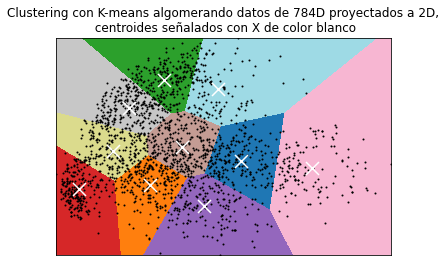

In [127]:
c1=kmeans28.cluster_centers_
title=('Clustering con K-means algomerando datos de 784D proyectados a 2D,\n centroides señalados con X de color blanco')
plotting(xx,yy,Z,reduced_data28[samples28],c1,title=title)

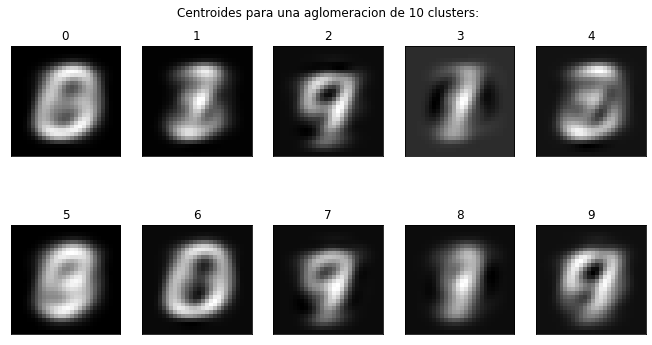

In [128]:
#Ahora, para mostrar los centroides como imagenes es necesario revertir
#la normalizacion y la proyeccion del PCA:
x=pca28.inverse_transform(c1)
#x=scaler28.inverse_transform(x)
titles=range(10)
dim=int(np.sqrt(nfeatures2))
plot_gallery(x,titles,dim,dim)

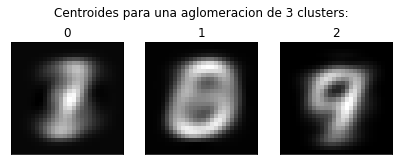

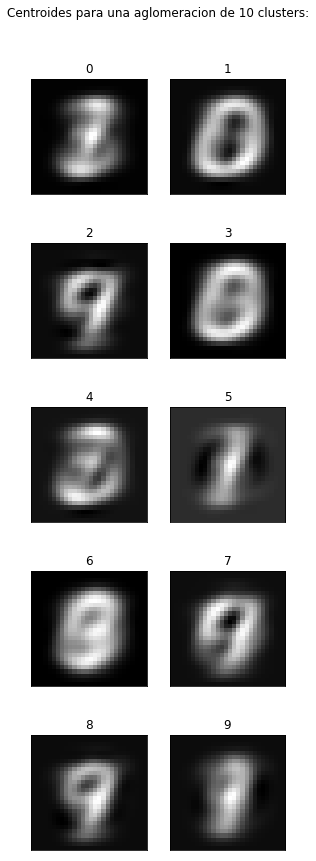

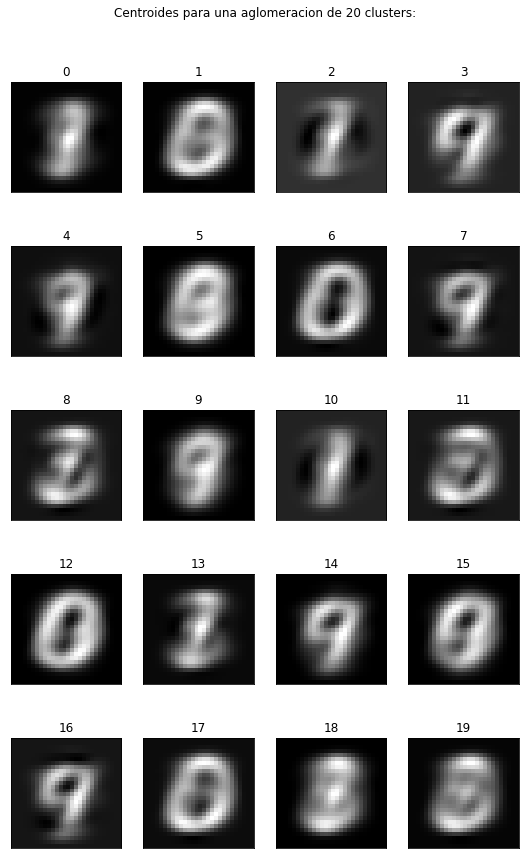

In [129]:
#Siguiendo la idea, se genera una funcion para aplicar esto a varios 
#numeros de clusters
k=[3,10,20]
showcentroids(reduced_data28,pca28,k)

# III Parte: Aglomeración en 64 dimensiones
Los codigos anteriores proyectaban los datos de 64 y 748 dimensiones a un espacio bidimensional y luego aglomeraban utilizando K-Means en dicho espacio 2D. 

Es posible que la aglomeración de resultados, sin embargo aplicar un PCA para reducir dimensiones implica la perdida de alguna parte de la información.Al proyectar y luego aglomerar, realmente se estan agrupando vectores de dos dimensiones, no imagenes de digitos compuestas por 64 (o 748) dimensiones. La información desechada podria ser relevante para distinguir un digito de otro, pero al proyectar al espacio bidimensional es posible que los conjuntos de cada digito se traslapen de manera que al agrupar los clusters no coincidan completamente con las clases.

La idea en esta tercera sección es aplicar los metodos en el orden inverso, es decir, aglomerando y luego proyectando para comparar la posición de los clusters resultantes (proyectados en 2D) con los clusters obtenidos anteriormente.

**Se utilizaran algunos datos calculados con anterioridad, por lo que es necesario haber ejecutado las celdas anteriores:**


In [130]:
#Agrupar los datos en 64 dimensiones:
kclass8_64=KMeans(n_clusters=ndigits,init='k-means++',n_init=10)
kclass8_64.fit(data8)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [131]:
#Se entrena el PCA de 64 a 2 dimensiones:
pca8=PCA(n_components=2)
pca8.fit(data8)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [132]:
#Ahora se proyectan los centroides de 64D a 2D:
c2=pca8.transform(kclass8_64.cluster_centers_)

In [133]:
#Se crea la grid en 2D
step=.02

x_min, x_max = reduced_data8[:, 0].min() - 1, reduced_data8[:, 0].max() + 1
y_min, y_max = reduced_data8[:, 1].min() - 1, reduced_data8[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

#Y se Predice:
Z=kmeans8.predict(np.c_[xx.ravel(),yy.ravel()])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


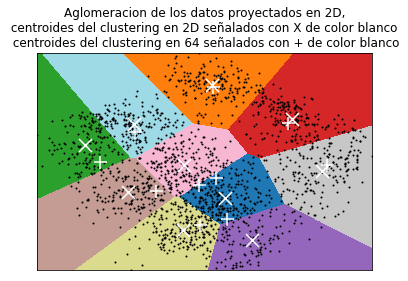

In [134]:
#Y se muestra el espacio bidimensional
c1=kmeans8.cluster_centers_
title=('Aglomeracion de los datos proyectados en 2D,\n centroides del clustering en 2D señalados con X de color blanco \n centroides del clustering en 64 señalados con + de color blanco')
plotting(xx,yy,Z,reduced_data8,c1,c2,title=title)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


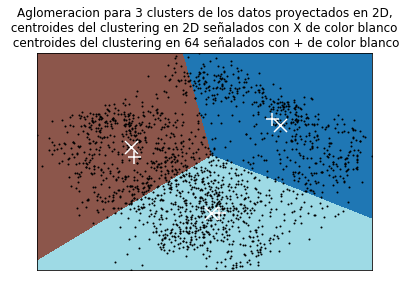

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


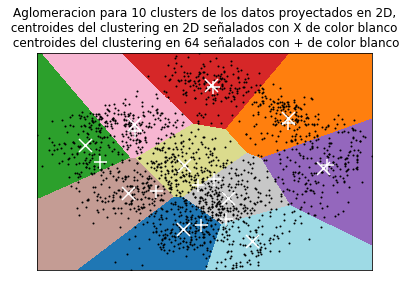

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


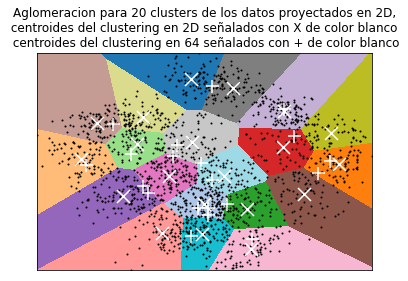

In [135]:
#Ahora se busca mostrar este mismo espacio con diferente
#numero de clusters para la aglomeración
ks=[3,10,20]
for k in ks:
  kclass8_64=KMeans(n_clusters=k,init='k-means++',n_init=10)
  kclass8_64.fit(data8)
  c2=pca8.transform(kclass8_64.cluster_centers_)
  
  kclass8_64.fit(reduced_data8)
  Z=kclass8_64.predict(np.c_[xx.ravel(),yy.ravel()])
  c1=kclass8_64.cluster_centers_
  title=('Aglomeracion para %i clusters de los datos proyectados en 2D,\n centroides del clustering en 2D señalados con X de color blanco \n centroides del clustering en 64 señalados con + de color blanco' %k)
  
  plotting(xx,yy,Z,reduced_data8,c1,c2,title=title)

**Algunas observaciones:**
  Es posible observar que existen diferencias entre los clusters marcados, especialmente conforme aumenta el numero de clusters con los que aglomera el KMeans. Queda claro que hay mucha diferencia en el espacio en el cual se aglomera. Ahora, analizando el desempeño del clasificador en 64 dimensiones:

In [136]:
#Evaluando los metodos para distintas dimensiones
kclass8_64=KMeans(n_clusters=ndigits,init='k-means++',n_init=10)
print('Agrupando en 2 dimensiones con 10 clusters:\n')
bench_k_means(kclass8_64,name='k-means++',data=reduced_data8,labels=labels8)
print('Agrupando en 64 dimensiones con 10 clusters:\n')
bench_k_means(kclass8_64,name='k-means++',data=data8,labels=labels8)


Agrupando en 2 dimensiones con 10 clusters:

init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________
k-means++	0.15s	56213	0.526	0.529	0.527	0.395	0.523	0.406
Agrupando en 64 dimensiones con 10 clusters:

init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________
k-means++	0.33s	1165295	0.736	0.743	0.739	0.664	0.737	0.179


**Observaciones:**
Puede observarse que las metricas para la aglomeracion en 64 dimensiones son mucho mejores que las realizadas en 2 dimensiones. La diferencia en los tiempos es esperable pues la cantidad de dimensiones es mucho mayor y por lo tanto los calculos son mas lentos. Tambien es esperable que la aglomeracion en las dimensiones originales sea mejor, esto refuerza lo mencionado con anterioridad acerca de la perdida de información que implica usar un PCA como reductor de dimensiones. La unica excepcion es la metrica de silhoutte, que sugiere que en un espacio de dos dimensiones, los clusters proyectados estan mejor definidos.

Es de esperar tambien que las imagenes de los centroides sean distintos para una aglomeración en 64D proyectada a 2D:


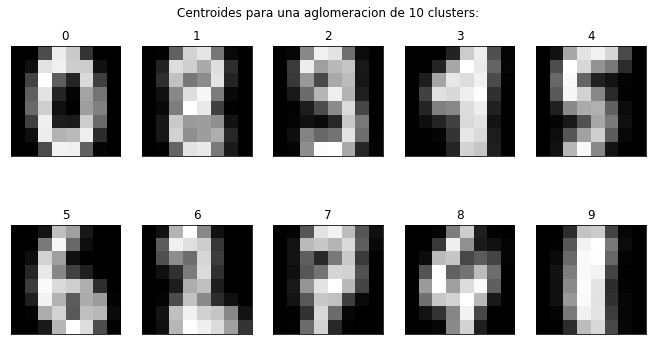

In [137]:
#Para mostrar los centroides del KMeans en 64 dimensiones
kclass8_64.fit(data8)
c1=kclass8_64.cluster_centers_
#x=scaler8.inverse_transform(c1)
titles=range(10)
dim=int(np.sqrt(nfeatures))
plot_gallery(c1,titles,dim,dim)

**Observaciones:**
En este caso los centroides son claramente mas representativos, incluso se puede distinguir los digitos a los que correponden en algunos casos. Una vez mas se refuerza la idea de que realizar la aglomeración en 64 dimensiones agrupa mejor los datos como un clasificador.


#IV Parte: Aglomeración en 748D para MNIST 28x28

Ahora se realizan las pruebas anteriores en el caso del set de digitos con dimensiones 28x28

In [138]:
#Agrupar los datos en 748 dimensiones
kclass28_748=KMeans(n_clusters=ndigits,init='k-means++',n_init=10)
kclass28_748.fit(data28)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [139]:
#Se entrena el PCA de 748 a 2 dimensiones
pca28=PCA(n_components=2)
pca28.fit(data28)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [140]:
#Ahora se proyectan los centroides de 64D a 2D
c2=pca28.transform(kclass28_748.cluster_centers_)

In [141]:
#Se hace la grid para mostrar el espacio 2D
step=1

x_min, x_max = reduced_data28[:, 0].min() - 1, reduced_data28[:, 0].max() + 1
y_min, y_max = reduced_data28[:, 1].min() - 1, reduced_data28[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

#Y se Predice:
Z=kmeans28.predict(np.c_[xx.ravel(),yy.ravel()])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


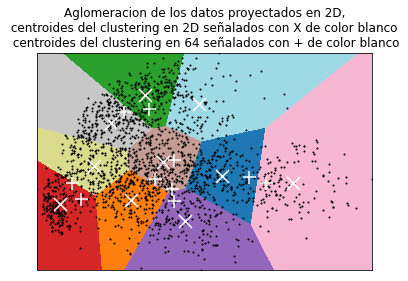

In [142]:
#Y se muestra el espacio bidimensional
c1=kmeans28.cluster_centers_
title=('Aglomeracion de los datos proyectados en 2D,\n centroides del clustering en 2D señalados con X de color blanco \n centroides del clustering en 64 señalados con + de color blanco')
plotting(xx,yy,Z,reduced_data28[samples28],c1,c2,title=title)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


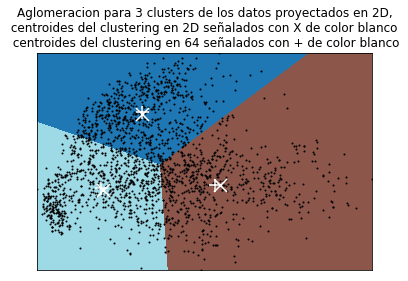

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


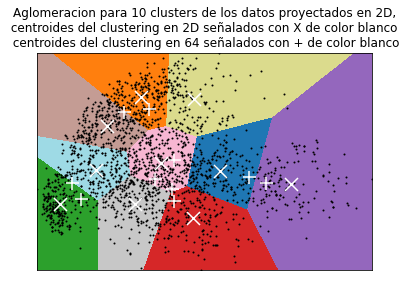

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


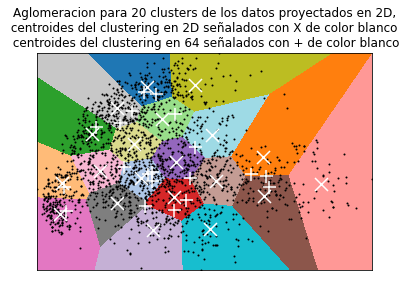

In [143]:
#Ahora se busca mostrar este mismo espacio con diferente
#numero de clusters para la aglomeración
ks=[3,10,20]
for k in ks:
  kclass28_748=KMeans(n_clusters=k,init='k-means++',n_init=10)
  kclass28_748.fit(data28)
  c2=pca28.transform(kclass28_748.cluster_centers_)
  
  kclass28_748.fit(reduced_data28)
  Z=kclass28_748.predict(np.c_[xx.ravel(),yy.ravel()])
  c1=kclass28_748.cluster_centers_
  title=('Aglomeracion para %i clusters de los datos proyectados en 2D,\n centroides del clustering en 2D señalados con X de color blanco \n centroides del clustering en 64 señalados con + de color blanco' %k)
  
  plotting(xx,yy,Z,reduced_data28[samples28],c1,c2,title=title)

In [144]:
#Evaluando los metodos para distintas dimensiones:
kclass28_748=KMeans(n_clusters=ndigits,init='k-means++',n_init=10)
print('Agrupando en 2 dimensiones con 10 clusters:')
bench_k_means(kclass28_748,name='k-means++',data=reduced_data28,labels=labels28)
print('Agrupando en 748 dimensiones con 10 clusters:')
bench_k_means(kclass28_748,name='k-means++',data=data28,labels=labels28)

Agrupando en 2 dimensiones con 10 clusters:
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________
k-means++	4.42s	3837042598	0.352	0.356	0.354	0.231	0.354	0.327
Agrupando en 748 dimensiones con 10 clusters:
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
__________________________________________________________________________________
k-means++	125.12s	152992613303	0.485	0.496	0.491	0.361	0.491	0.071


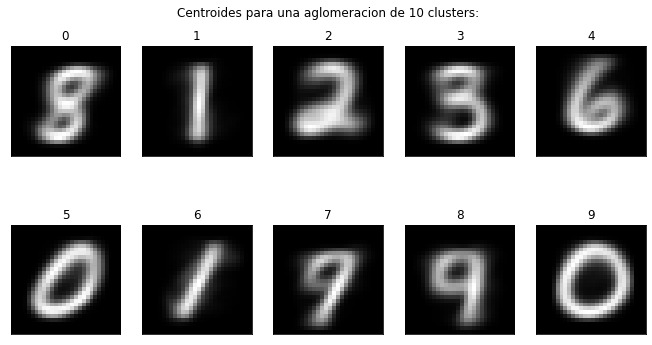

In [145]:
#Para mostrar los centroides del KMeans en 64 dimensiones
kclass28_748.fit(data28)
c2=kclass28_748.cluster_centers_
#x=scaler28.inverse_transform(c2)
titles=range(10)
dim=int(np.sqrt(nfeatures2))
plot_gallery(c2,titles,dim,dim)

**Observaciones:**
Nuevamente se pueden observar las mejoras de agrupar en las dimensiones originales de los datos. Se observan las diferencias entre los puntos marcados en el espacio bidimensional, las metricas de desempeño y los centroides mostrados como imagenes mas representativas y definidas. 
Además, en la proyección bidimensional, se puede ver que algunos centroides marcados en cruces (que corresponden a la algomeración en el espacio original de 748 dimensiones) estan muy cercanos entre si, esta puede ser la razon por la cual la metrica de silhoutte es mas baja, pues para el algoritmo es mas dificil asignar con seguridad los datos a clusters cuyos centroides estan muy cerca.

#V Parte: Reducción de dimensiones usando solo centroides
Aunque anteriormente se necesitaba revertir la reduccion de dimensiones solo en los centroides, el entrenamiento del PCA fue realizado con el conjunto completo de los datos. La idea es que el PCA pueda aprender a reducir las dimensiones de mejor forma al utilizar todos los datos. Sin embargo, ¿que efecto tendría aplicar PCA solo a los datos que requieran su uso?

Para esto, se modifica la función que muestra los centroides como imagenes de manera que solo se usen sus componentes principales para el proceso:

In [146]:
#Agrupar los datos en 64 dimensiones
kclass8_64=KMeans(n_clusters=ndigits,init='k-means++',n_init=10)
kclass8_64.fit(data8)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [147]:
#Se crea la grid en 2D
step=.02

x_min, x_max = reduced_data8[:, 0].min() - 1, reduced_data8[:, 0].max() + 1
y_min, y_max = reduced_data8[:, 1].min() - 1, reduced_data8[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

#Y se Predice:
Z=kmeans8.predict(np.c_[xx.ravel(),yy.ravel()])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


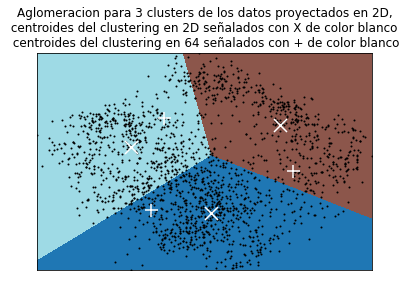

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


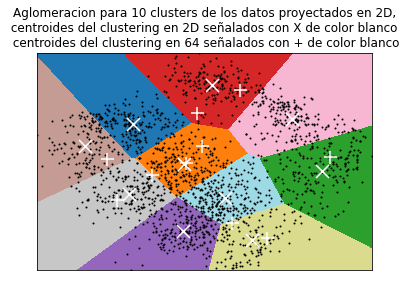

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


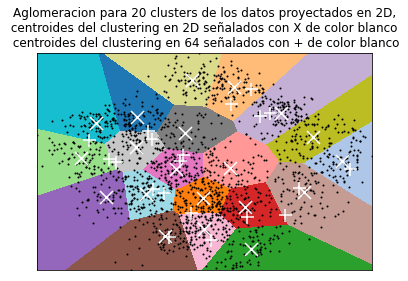

In [148]:
#Ahora se busca mostrar este mismo espacio con diferente
#numero de clusters para la aglomeración proyectando unicamente
#con los centroides calculados
ks=[3,10,20]
for k in ks:
  kclass8_64=KMeans(n_clusters=k,init='k-means++',n_init=10)
  kclass8_64.fit(data8)
  c2=pca8.fit_transform(kclass8_64.cluster_centers_)
  
  kclass8_64.fit(reduced_data8)
  Z=kclass8_64.predict(np.c_[xx.ravel(),yy.ravel()])
  c1=kclass8_64.cluster_centers_
  title=('Aglomeracion para %i clusters de los datos proyectados en 2D,\n centroides del clustering en 2D señalados con X de color blanco \n centroides del clustering en 64 señalados con + de color blanco' %k)
  
  plotting(xx,yy,Z,reduced_data8,c1,c2,title=title)

Ahora para los datos de 28x28:

In [149]:
#Agrupar los datos en 28 dimensiones
kclass28_748=KMeans(n_clusters=ndigits,init='k-means++',n_init=10)
kclass28_748.fit(data28)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [150]:

#Se crea la grid en 2D
step=1

x_min, x_max = reduced_data28[:, 0].min() - 1, reduced_data28[:, 0].max() + 1
y_min, y_max = reduced_data28[:, 1].min() - 1, reduced_data28[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

#Y se Predice:
Z=kmeans28.predict(np.c_[xx.ravel(),yy.ravel()])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


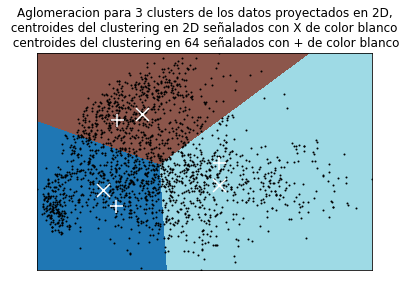

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


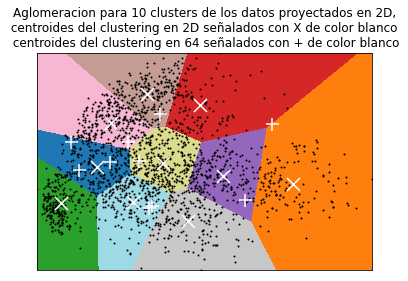

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


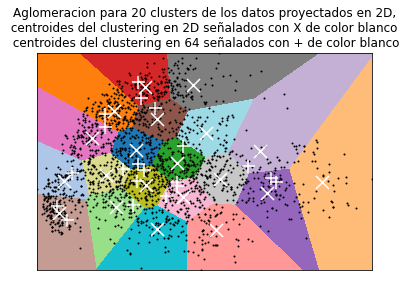

In [154]:
#Ahora se busca mostrar este mismo espacio con diferente
#numero de clusters para la aglomeración proyectando unicamente
#con los centroides calculados
ks=[3,10,20]
for k in ks:
  kclass28_748=KMeans(n_clusters=k,init='k-means++',n_init=10)
  kclass28_748.fit(data28)
  c2=pca28.fit_transform(kclass28_748.cluster_centers_)
  
  kclass28_748.fit(reduced_data28)
  Z=kclass28_748.predict(np.c_[xx.ravel(),yy.ravel()])
  c1=kclass28_748.cluster_centers_
  title=('Aglomeracion para %i clusters de los datos proyectados en 2D,\n centroides del clustering en 2D señalados con X de color blanco \n centroides del clustering en 64 señalados con + de color blanco' %k)
  
  plotting(xx,yy,Z,reduced_data28[samples28],c1,c2,title=title)

**Observaciones:** Para casos con numero de clusters bajos, no es muy notable  la diferencia. Sin embargo comparando con las graficas en las que el PCA es entrenado con todos los datos se observan claras diferencias en la posicion de los centroides. Al realizar pca solo con los centroides, este estima las direcciones de maxima variacion sin tomar en cuenta el efecto de los datos. En este sentido el PCA solo extrae las componentes principales de datos representativos de cada cluster y no se ve afectado por la distribucion de los datos, la extraccion requiere menos datos en este caso, no contempla las variaciones de todo el conjunto y no se puede ver afectado por datos atipicos que le hagan pensar al PCA que hay una variacion muy en grande en direcciones donde solo hay ruido.